In [1]:
# %matplotlib notebook
%matplotlib inline
from __future__ import print_function
from dolfin import *
import dolfin.cpp as cpp
import ufl
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
import matplotlib.tri as tri
import logging
logging.getLogger("FFC").setLevel(logging.WARNING)

In [2]:
def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def mplot_cellfunction(cellfn):
    C = cellfn.array()
    tri = mesh2triang(cellfn.mesh())
    return plt.tripcolor(tri, facecolors=C)

def mplot_function(f):
    mesh = f.function_space().mesh()
    if (mesh.geometry().dim() != 2):
        raise AttributeError('Mesh must be 2D')
    # DG0 cellwise function
    if f.vector().size() == mesh.num_cells():
        C = f.vector().array()
        return plt.tripcolor(mesh2triang(mesh), C)
    # Scalar function, interpolated to vertices
    elif f.value_rank() == 0:
        C = f.compute_vertex_values(mesh)
        return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    # Vector function, interpolated to vertices
    elif f.value_rank() == 1:
        w0 = f.compute_vertex_values(mesh)
        if (len(w0) != 2*mesh.num_vertices()):
            raise AttributeError('Vector field must be 2D')
        X = mesh.coordinates()[:, 0]
        Y = mesh.coordinates()[:, 1]
        U = w0[:mesh.num_vertices()]
        V = w0[mesh.num_vertices():]
        return plt.quiver(X,Y,U,V)

# Plot a generic dolfin object (if supported)
def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, Function):
        return mplot_function(obj)
    elif isinstance(obj, CellFunctionSizet):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionDouble):
        return mplot_cellfunction(obj)
    elif isinstance(obj, CellFunctionInt):
        return mplot_cellfunction(obj)
    elif isinstance(obj, Mesh):
        if (obj.geometry().dim() != 2):
            raise AttributeError('Mesh must be 2D')
        return plt.triplot(mesh2triang(obj), color='#808080')

    raise AttributeError('Failed to plot %s'%type(obj))
# end of commands for plotting

In [3]:
radiusOut = 30
thetaSL = 0.2
thetaSR = 0.2
radiusL = 1
radiusR = 1
d = 4
d_array = []
E_array = []
D_array = []
D = 1

In [4]:
for i in range(0,7):
    Out = Circle(Point(0,0),radiusOut)
    cL = Circle(Point(-(d/2),0),radiusL)
    cR = Circle(Point((d/2),0),radiusR)
    domain = Out - cL - cR

    res = 200
    mesh = generate_mesh(domain, res)
    
    class outside_border(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-1
            return on_boundary and abs( sqrt(x[0]*x[0] + x[1]*x[1]) - radiusOut) < tol

    class circleR(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-1
            return on_boundary and abs(sqrt( (x[0] - (d/2))*(x[0] - (d/2)) + x[1]*x[1]) - radiusR) < tol

    class circleL(SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-1
            return on_boundary and abs(sqrt( (x[0] + (d/2))*(x[0] + (d/2)) + x[1]*x[1]) - radiusL) < tol

    outside_border=outside_border()
    circleR=circleR()
    circleL=circleL()

    boundaries = FacetFunction("size_t", mesh)
    boundaries.set_all(0)

    outside_border.mark(boundaries,1)
    circleL.mark(boundaries,2)
    circleR.mark(boundaries,3)

    V = FunctionSpace(mesh,'CG',2)

    #Boundary Conditions
    #Right hand cylinder is always counter clockwise orientation
    nxR = Expression('-x[1]*sin(thetaSR)/sqrt((x[0] - (d/2))*(x[0] - (d/2)) + x[1]*x[1])',thetaSR = thetaSR, d = d)
    nyR = Expression('(x[0] - (d/2))*sin(thetaSR)/sqrt((x[0] - (d/2))*(x[0] - (d/2)) + x[1]*x[1])',thetaSR = thetaSR, d = d)

    #Same signs for same chirality, opposite signs for opposite chirality
    nxL = Expression('-x[1]*sin(thetaSL)/sqrt((x[0] + (d/2))*(x[0] + (d/2)) + x[1]*x[1])',thetaSL = thetaSL, d = d)
    nyL = Expression('(x[0] + (d/2))*sin(thetaSL)/sqrt((x[0] + (d/2))*(x[0] + (d/2)) + x[1]*x[1])',thetaSL = thetaSL, d = d)

    #For nx
    bcs1 = [DirichletBC(V, 0, boundaries, 1),
            DirichletBC(V, nxL, boundaries, 2),
            DirichletBC(V, nxR, boundaries, 3)]
    #for ny
    bcs2 = [DirichletBC(V, 0, boundaries, 1),
            DirichletBC(V, nyL, boundaries, 2),
            DirichletBC(V, nyR, boundaries, 3)]

    nx = TrialFunction(V)
    ny = TrialFunction(V)
    v1 = TestFunction(V)
    v2 = TestFunction(V)

    f = Constant(0.0)
    g = Constant(D**-2)
    
    a1 = (inner(nabla_grad(nx), nabla_grad(v1)) + g*(inner(nx,v1)))*dx
    a2 = (inner(nabla_grad(ny), nabla_grad(v2)) + g*(inner(ny,v2)))*dx
    L1 = f*v1*dx
    L2 = f*v2*dx
    nx = Function(V)
    ny = Function(V)
    solve(a1 == L1, nx, bcs1)
    solve(a2 == L2, ny, bcs2)

    V_d = VectorFunctionSpace(mesh,'Lagrange',1)
    w1 = TrialFunction(V_d)
    w2 = TrialFunction(V_d)
    q1 = TestFunction(V_d)
    q2 = TestFunction(V_d)

    a3 = inner(w1,q1)*dx
    a4 = inner(w2,q2)*dx
    L3 = inner(grad(nx),q1)*dx
    L4 = inner(grad(ny),q2)*dx
    grad_nx = Function(V_d)
    grad_ny = Function(V_d)
    solve(a3 == L3, grad_nx)
    solve(a4 == L4, grad_ny)

    dxnx, dynx = grad_nx.split(deepcopy=True)
    dxny, dyny = grad_ny.split(deepcopy=True)

    cell_markers = CellFunction("uint", mesh)
    dx1 = Measure("dx", domain=mesh, subdomain_data=cell_markers)

    splay = pow(dxnx+dyny,2)
    twist = pow(dxny-dynx,2)
#     field = g*(pow(nx,2) + pow(ny,2) - 1)/2
    field = g*(pow(nx,2) + pow(ny,2))/2
    
    f1 = splay + twist + field
    
    F1 = project(f1,V)
    
    Esplay = assemble(splay*dx1)
    Etwist = assemble(twist*dx1)
    Efield = assemble(field*dx1)
    
    Etot = Esplay + Etwist + Efield

    d_array.append(d)
    D_array.append(D)
    E_array.append(Etot)
    D += 1

In [5]:
print('E-field Energy %f' % Efield)
print('Splay Energy %f' % Esplay)
print('Twist Energy %f' % Etwist)
print('Total Energy %f' % Etot)

E-field Energy 0.104432
Splay Energy 0.000365
Twist Energy 0.152868
Total Energy 0.257665


In [ ]:
plt.figure(figsize=(10,10))
plot(F1)
plt.colorbar(shrink=0.8);

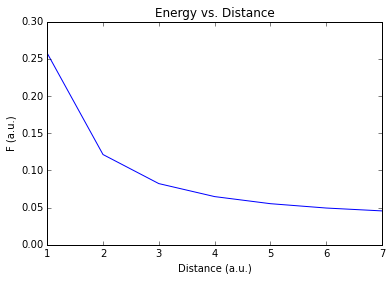

In [6]:
# print(E_array)
# print(d_array)

plt.figure()
plt.plot(D_array,E_array)
plt.title("Energy vs. Distance")
plt.xlabel('Distance (a.u.)')
plt.ylabel('F (a.u.)');